In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import random
random.seed(42)

In [63]:
!pip install lightgbm

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import gc
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [65]:
def reduce_mem_usage(df):

    import numpy as np

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [66]:
df_train = pd.read_csv('train_V2.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [67]:
df_train = reduce_mem_usage(df_train)

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [69]:
pd.set_option('display.max_columns', 500)

In [70]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [71]:
df_test = pd.read_csv('test_V2.csv')

In [72]:
df_test = reduce_mem_usage(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [73]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [74]:
df_train.dropna(inplace=True)

In [75]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [76]:
print(len(df_train))
print(len(df_test))

4446965
1934174


In [77]:
target = 'winPlacePerc'

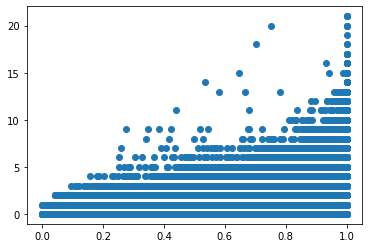

In [78]:
kills_sorted = df_train[df_train.matchType == "solo"][:100000].sort_values("kills")

plt.scatter(kills_sorted[target], kills_sorted.kills)

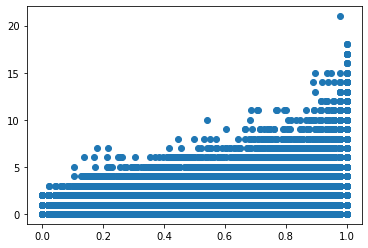

In [79]:
kills_sorted = df_train[df_train.matchType == "duo"][:100000].sort_values("kills")

plt.scatter(kills_sorted[target], kills_sorted.kills)

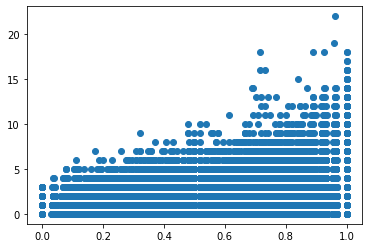

In [80]:
kills_sorted = df_train[df_train.matchType == "squad"][:100000].sort_values("kills")

plt.scatter(kills_sorted[target], kills_sorted.kills)

## VISUALIZATIONS

In [81]:
def visualization (col, num_bin=10):
    title = col[0].upper() + col[1:]
    f,axes=plt.subplots()
    plt.xlabel(title)
    plt.ylabel('Log Count')
    axes.set_yscale('log')
    df_train.hist(column=col,ax=axes,bins=num_bin)
    plt.title('Histogram of ' + title)
    plt.show()
    
    tmp = df_train[col].value_counts().sort_values(ascending=False)

    print('Min value of ' + title + ' is: ',min(tmp.index))
    print('Max value of ' + title + ' is: ',max(tmp.index))

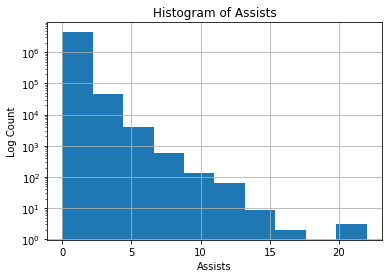

Min value of Assists is:  0
Max value of Assists is:  22


In [82]:
visualization('assists')

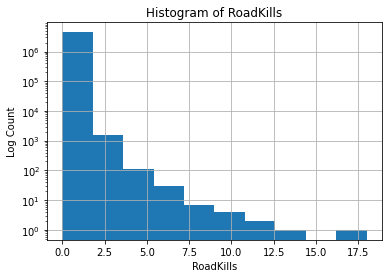

Min value of RoadKills is:  0
Max value of RoadKills is:  18


In [83]:
visualization('roadKills')

In [84]:
# here most of the players have road kills from  0 to 10 
# so we drop all the players who have more than 10 roadkills making this to remove outliers from my data
# drop all the road kills above 10.

#train data
df_train.drop(df_train[df_train['roadKills']>=10].index,inplace=True)

#test data
df_test.drop(df_test[df_test['roadKills']>=10].index,inplace=True)

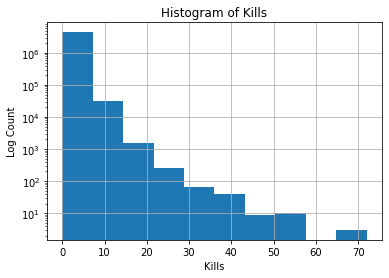

Min value of Kills is:  0
Max value of Kills is:  72


In [85]:
visualization('kills')

In [86]:
# Dropping outliers 
df_train.drop(df_train[df_train['kills']>=35].index,inplace=True)
df_test.drop(df_test[df_test['kills']>=35].index,inplace=True)

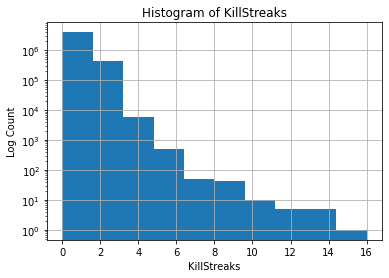

Min value of KillStreaks is:  0
Max value of KillStreaks is:  16


In [87]:
visualization('killStreaks')

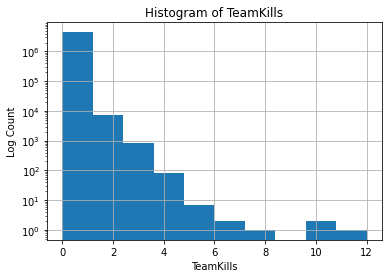

Min value of TeamKills is:  0
Max value of TeamKills is:  12


In [88]:
visualization('teamKills')

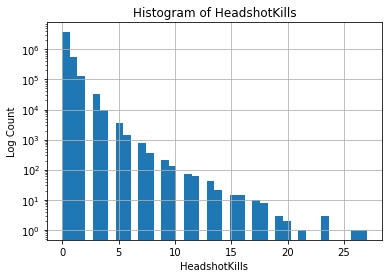

Min value of HeadshotKills is:  0
Max value of HeadshotKills is:  27


In [89]:
visualization('headshotKills', num_bin=40)

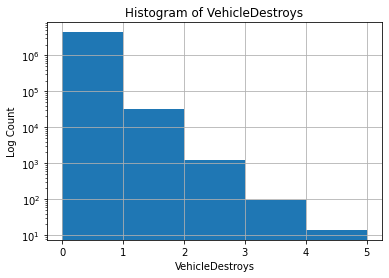

Min value of VehicleDestroys is:  0
Max value of VehicleDestroys is:  5


In [90]:
visualization('vehicleDestroys',num_bin=5)

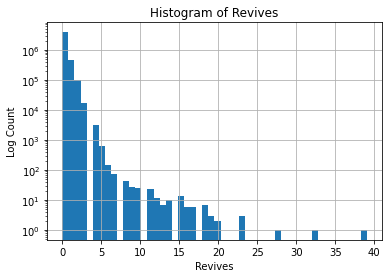

Min value of Revives is:  0
Max value of Revives is:  39


In [91]:
visualization('revives',num_bin=50)

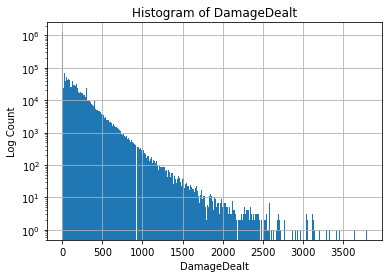

Min value of DamageDealt is:  0.0
Max value of DamageDealt is:  3796.0


In [92]:
visualization('damageDealt', num_bin=1000)

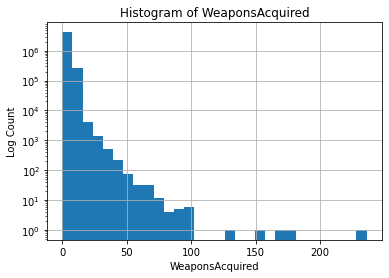

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  236


In [93]:
visualization('weaponsAcquired',num_bin=30)

In [94]:
# removing the outliers.
#train
df_train.drop(df_train[df_train.weaponsAcquired>=50].index,inplace=True)
#test
df_test.drop(df_test[df_test.weaponsAcquired>=50].index,inplace=True)

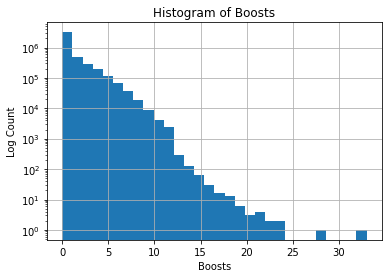

Min value of Boosts is:  0
Max value of Boosts is:  33


In [95]:
visualization('boosts',num_bin=30)

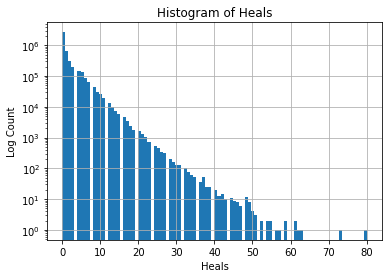

Min value of Heals is:  0
Max value of Heals is:  80


In [96]:
visualization('heals', num_bin=100)

In [97]:
# removing the outliers.

#train
df_train.drop(df_train[df_train.heals>=40].index,inplace=True)

#test

df_test.drop(df_test[df_test.heals>=40].index,inplace=True)

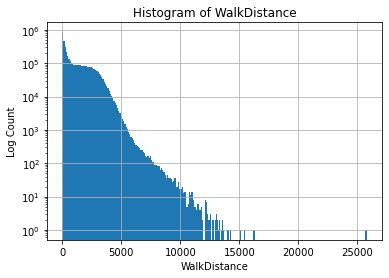

Min value of WalkDistance is:  0.0
Max value of WalkDistance is:  25776.0


In [98]:
visualization('walkDistance',num_bin=250)

In [99]:
#Removing the outliers

#train
df_train.drop(df_train[df_train['walkDistance']>=10000].index,inplace=True)


#test
df_test.drop(df_test[df_test['walkDistance']>=10000].index,inplace=True)

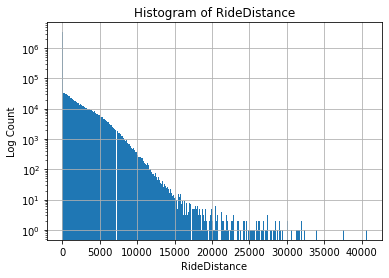

Min value of RideDistance is:  0.0
Max value of RideDistance is:  40704.0


In [100]:
visualization('rideDistance',num_bin=500)

In [101]:


#Removing the outliers.

#test

df_train.drop(df_train[df_train.rideDistance >=15000].index, inplace=True)

#test

df_test.drop(df_test[df_test.rideDistance >=15000].index, inplace=True)



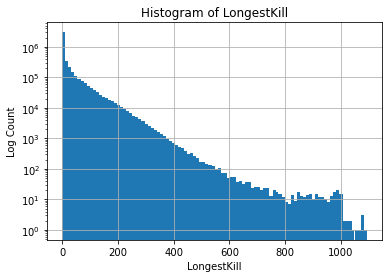

Min value of LongestKill is:  0.0
Max value of LongestKill is:  1094.0


In [102]:
visualization('longestKill', num_bin=100)

Here allmost all kills are between 100 meters as maximum of range there are some ouliers like 1000 meters range may be done by any of hackers

In [103]:
# drop outliers.      


#train
df_train.drop(df_train[df_train['longestKill']>=1000].index,inplace=True)

#test

df_test.drop(df_test[df_test['longestKill']>=1000].index,inplace=True)

In [104]:
df_train.shape

(4445866, 29)

We need to create a dummy variable because the initial shape is (4445866, 29) we have removed around 1000 to 1200 rows approx as outliers which is found to be final shape as (4444666, -)

In [105]:
#Creating a dummy variable for categorical data values

df_train=pd.get_dummies(df_train,columns=['matchType'])
df_test=pd.get_dummies(df_test,columns=['matchType'])

## CORRELATION ANALYSIS

In [106]:
cols_to_drop = ['Id','matchId','groupId','matchType']
cols_to_fit = [col for col in df_train.columns if col not in cols_to_drop]
corr = df_train[cols_to_fit].corr()

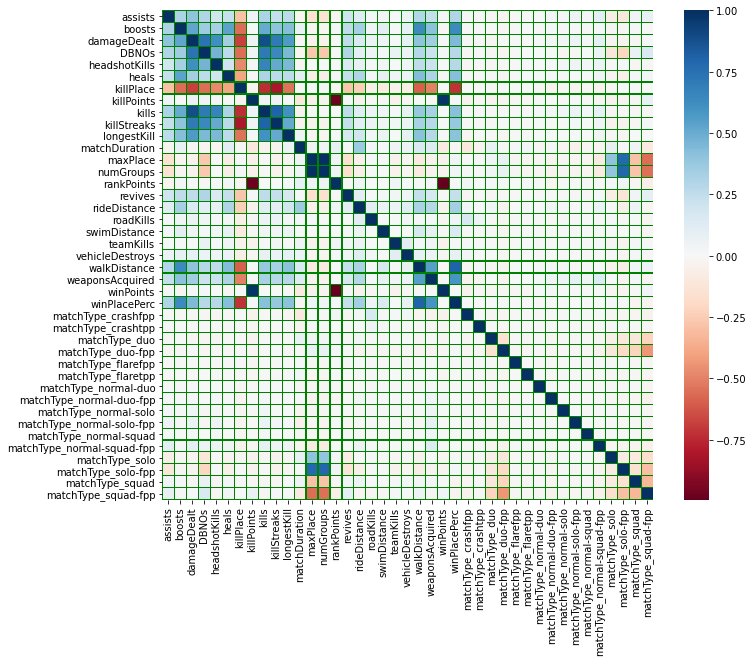

In [107]:
plt.figure(figsize=(11,9))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,linecolor='green',linewidths=0.1,cmap='RdBu')
plt.show()

In [108]:
t = df_train
t =t.drop(['Id','groupId','matchId',],axis=1)
y = t['winPlacePerc']
X = t.drop(['winPlacePerc'],axis=1)
X_train = df_train.drop(['Id','groupId','matchId'],axis=1)
X_test = df_test.drop(['Id','groupId','matchId'],axis=1)

In [109]:
#splitting the data into training and testing by using train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)
len(X_train)

gc.collect()

25776

## LIGHTGBM MODEL 

In [110]:
import lightgbm as lgbm

In [111]:
def calculate_error(cl,name):
  print(name)
  y_pre = cl.predict(X_val)
  print('Mean Absolute Error is {:.5f}'.format(mean_absolute_error(y_val,y_pre)))
  print('R2 score is {:.2%}'.format(r2_score(y_val, cl.predict(X_val))))

In [112]:
# Creating required parameters for search
params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 
              'early_stopping_rounds':200, "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7, "bagging_seed" : 0, "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
lgbTrain = lgbm.Dataset(X_train, label=y_train)
lgbVal = lgbm.Dataset(X_val, label=y_val)
model = lgbm.train(params,lgbTrain,valid_sets=[lgbTrain, lgbVal],
                      early_stopping_rounds=200, verbose_eval=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2830
[LightGBM] [Info] Number of data points in the train set: 3112106, number of used features: 40
[LightGBM] [Info] Start training from score 0.472797
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0565657	valid_1's l1: 0.0568135
[2000]	training's l1: 0.055849	valid_1's l1: 0.0563082
[3000]	training's l1: 0.0553787	valid_1's l1: 0.0560348
[4000]	training's l1: 0.0549893	valid_1's l1: 0.0558295
[5000]	training's l1: 0.0546452	valid_1's l1: 0.0556652
[6000]	training's l1: 0.0543325	valid_1's l1: 0.0555209
[7000]	training's l1: 0.0540435	valid_1's l1: 0.0553976
[8000]	training's l1: 0.0537556	valid_1's l1: 0.0552686
[9000]	training's l1: 0.053508	valid_1's l1: 0.0551858
[10000]	training's l1: 0.

In [113]:
calculate_error(model,"LGBM")

LGBM
Mean Absolute Error is 0.05456
R2 score is 93.76%


In [114]:
y_predict = model.predict(X_test)

In [116]:
y_predict[y_predict > 1] = 1
y_predict[y_predict < 0] = 0
df_test['winPlacePerc'] = y_predict
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('WinnerPredictionseries.csv', index=False)

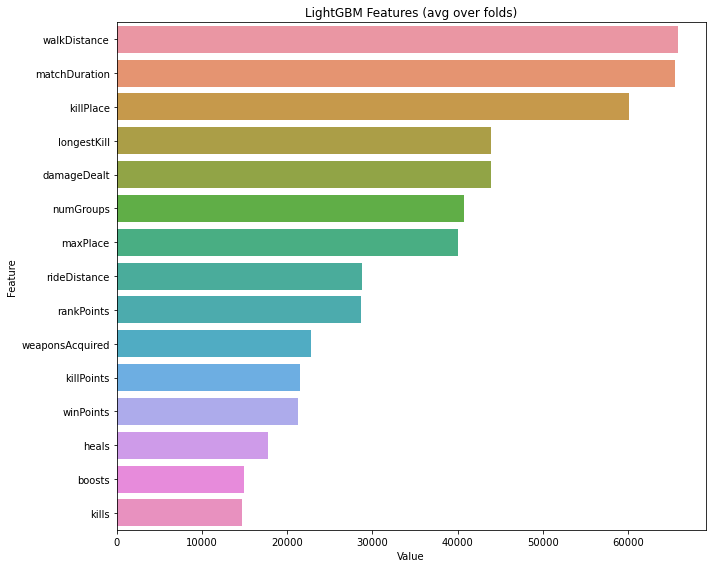

In [117]:
#Feature importance

cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
cols_to_fit = [col for col in X_train.columns if col not in cols_to_drop]
feature_importance = pd.DataFrame(sorted(zip(model.feature_importance(), cols_to_fit)), columns=['Value','Feature'])
feature_importance = feature_importance.tail(15)

plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig("lgbmfeatures.png",dpi=500)

## REGRESSION MODELS

In [78]:
def runAllModels(X_train, Y_train):
        
    linear = LinearRegression(copy_X=True)
    linear.fit(X_train,Y_train)
    calculate_error(linear,"linear")

    ridge = Ridge(copy_X=True)
    ridge.fit(X_train,Y_train)
    calculate_error(ridge,"ridge")
    
    lasso = Lasso(copy_X=True)
    lasso.fit(X_train,Y_train)
    calculate_error(lasso,"lasso")
    
    elastic = ElasticNet(copy_X=True)
    elastic.fit(X_train,Y_train)
    calculate_error(elastic,"elastic")
    
    ada = AdaBoostRegressor(learning_rate=0.8)
    ada.fit(X_train,Y_train)
    calculate_error(ada,"Adaboost")
    
    GBR = GradientBoostingRegressor(learning_rate=0.8)
    GBR.fit(X_train,Y_train)
    calculate_error(GBR,"GBR")

    forest = RandomForestRegressor(n_estimators=10)
    forest.fit(X_train,Y_train)
    calculate_error(forest,"forest")
    
    tree = DecisionTreeRegressor()
    tree.fit(X_train,Y_train)
    calculate_error(tree,"tree")

In [80]:
runAllModels(X_train,y_train)

linear
Mean Absolute Error is 0.08993
R2 score is 83.98%
ridge
Mean Absolute Error is 0.08992
R2 score is 83.98%
lasso
Mean Absolute Error is 0.12087
R2 score is 74.49%
elastic
Mean Absolute Error is 0.11302
R2 score is 77.13%
Adaboost
Mean Absolute Error is 0.09871
R2 score is 81.66%
GBR
Mean Absolute Error is 0.06200
R2 score is 92.17%
forest
Mean Absolute Error is 0.06062
R2 score is 92.26%
tree
Mean Absolute Error is 0.08111
R2 score is 85.65%
